In [212]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


**Resources** :

*Matrix Factorization techniques for Recommender Systems*, Koren (2009)    
https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf

Hands on Machine Learning with scikit-learn and tensorflow:             
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

The movieLens dataset:                                                
https://grouplens.org/datasets/movielens/ 

Keras Functional API doc :                                            
https://keras.io/guides/functional_api/


# Recommender systems : collaborative filtering via matrix factorization

Do you wonder how Netflix is able to recommend you movies despite it doesn't know anything about you but the ratings you gave to the movies you watched ? This is what we are going to explore during this 3 days machine learning module.

First off, let's learn about what are recommender system, collaborative filtering and matrix factorization techniques, which are all very well introduced in Koren's 2009 famous article : *Matrix Factorization techniques for Recommender Systems* : https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf . Read the 4 first pages (up to section *adding biases* included). 

Through this notebook we are going to re-implement the model described in the pages you read, and apply it to a classic movie ratings dataset coming from the website *movieLens*. To do so, we will use a powerful deep learning python library called *Keras*, that makes it easy to train complex models based on linear algebra.

## Load the dataset

For this module, we are going to use the movieLens dataset, that contains data from the movie recommending website movielens. The data is a subset of ratings from 0 to 5 given by some users of the website to a subset of movies. You can read more about it here (we are using the latest small dataset) : https://grouplens.org/datasets/movielens/ , and in the *README* file that is in the *data/ml-latest-small/* folder.

Load the ratings data from the `ratings.csv` file into a dataframe. The userId and movieId provided in the file don't start from 0, and are not contiguous (i.e. there are missing indexes).

Re-index the user and movie ids to indexes going from 0 to `nb_users` and 0 to `nb_movies` respectively, by building two dictionnaries `user_ids_map` and `movie_ids_map` that maps the file ids to your new ids. 
And finally, split the rows of this dataframe in a random 90%/10% train/test sets.

To do so, fill the `get_train_test_sets` function below, and respect the returned objects structures that are described in the docstring.


In [213]:
data_path= '/home/elie.poncet@Digital-Grenoble.local/Documents/ML4/ML4/data/ml-latest-small/ratings.csv'

In [214]:
import pandas as pd
df = pd.read_csv(data_path)

In [6]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,Index_copy,userId
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
100831,100831,610
100832,100832,610
100833,100833,610
100834,100834,610


AttributeError: 'SeriesGroupBy' object has no attribute 'reset_index'

In [224]:
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split

In [225]:
def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.    Input:
        data_path : string : the path to the ratings file
        train_prop : float : The proportion of the training set    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0.
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    # Load data
    df = pd.read_csv(data_path)
    # Extract unique user and movie ids and sort them
    unique_user_ids = sorted(df['userId'].unique())
    unique_movie_ids = sorted(df['movieId'].unique())
    # Create dictionaries to map file ids to new ids
    user_ids_map = {user_id: index for index, user_id in enumerate(unique_user_ids)}
    movie_ids_map = {movie_id: index for index, movie_id in enumerate(unique_movie_ids)}
    # Replace the user and movie ids with new ids
    df['userId'] = df['userId'].apply(lambda x: user_ids_map[x])
    df['movieId'] = df['movieId'].apply(lambda x: movie_ids_map[x])
    nb_users = len(user_ids_map)
    nb_movies = len(movie_ids_map)
    # Split the data between train and test
    train, test  = train_test_split(df, test_size=1-train_prop, random_state=42)
    
    # Create a DataFrame with the mapping between the old and new movieIds
    movies_df = pd.DataFrame({'movieId': unique_movie_ids, 'new_movieId': list(movie_ids_map.values())})
    
    # Map the new_movieId values to the Movies DataFrame
    movies['new_movieId'] = movies['movieId'].map(dict(zip(movies_df['movieId'], movies_df['new_movieId'])))

    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map


In [227]:
ratings_s_path =  '../data/ml-latest-small/ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

print("There are %i movies, %i users, and %i ratings" % (nb_movies, nb_users, dataset.shape[0]))

There are 9724 movies, 610 users, and 100836 ratings


In [228]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

Let's have a quick look at the ratings distribution:

<AxesSubplot: >

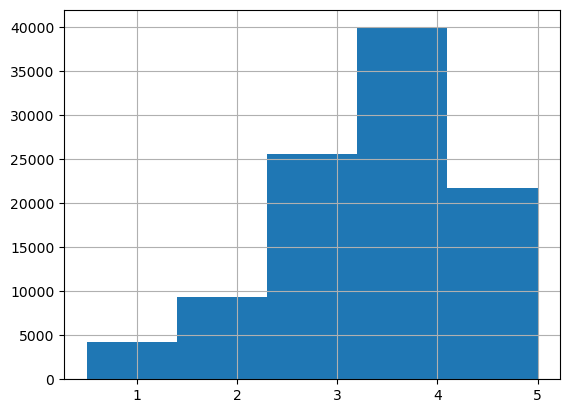

In [10]:
dataset['rating'].hist(bins=5)

In this dataset there are a lot of missing values, because not all the user/movie pairs have an associated rating. Indeed, each user rates only a few movies ! The goal of this notebook is to predict (some of) the missing user/movie ratings.

Print how many movies each of the 5 first users have rated, and print the percentage of available ratings in the whole dataset (i.e. the ratio between number of ratings and all the possible users/movies combinations):

In [18]:
(100836*100)/(610*9724)

1.6999683055613624

In [103]:
train

,userId,movieId,rating,timestamp
14430,90,1829,2.0,1112716724
43498,291,98,2.0,1265680159
73590,473,1321,3.5,1053021455
19181,123,97,3.5,1336584326
97254,604,3571,2.5,1277176881
...,...,...,...,...
6265,41,2986,4.0,996259059
54886,363,116,4.0,869443367
76820,479,4601,4.0,1179163171
860,5,748,3.0,845556567


In [219]:
train.pivot(index='userId',columns='movieId',values='rating')

movieId,0,1,2,3,4,5,6,7,8,9,...,9713,9714,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is only 1.7% of ratings that are available, which is normal as each hasn't rated all the movies. To see the dataset in a matrix form with all the missing ratings, use the `Dataframe.pivot()` function, with the `userId` as index, the `movieId` as columns, and the ratings for the `values` :

In [226]:
movies = pd.read_csv('/home/elie.poncet@Digital-Grenoble.local/Documents/ML4/ML4/data/ml-latest-small/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [230]:
movies = movies.rename(columns={'movieId': 'old_movieId'})
movies = movies.rename(columns={'new_movieId': 'movieId'})

In [264]:
movies = movies.dropna(subset=['movieId'])

In [231]:
movies

,old_movieId,title,genres,movieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0
2,3,Grumpier Old Men (1995),Comedy|Romance,2.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.0
4,5,Father of the Bride Part II (1995),Comedy,4.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9719.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9720.0
9739,193585,Flint (2017),Drama,9721.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9722.0


In [65]:


movies

,old_movieId,title,genres,movieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0
2,3,Grumpier Old Men (1995),Comedy|Romance,2.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.0
4,5,Father of the Bride Part II (1995),Comedy,4.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9719.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9720.0
9739,193585,Flint (2017),Drama,9721.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9722.0


In [23]:
lignes = df.loc[9255]
lignes[1]

2858.0

Print all the ratings of user 1. To do so, use the *movies.csv* file and your `movie_ids_map` dictionnary to find the movie title from the new movie indexes, and print the real movie title associated to each rating of user 1 :

In [232]:
user1_ratings_df = train[train['userId'] == 0]
i=0
for index, row in user1_ratings_df.iterrows():

    movie_id = row['movieId']
    rating = row['rating']
    movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].iloc[0]
    
    print(f'User 1 rated "{movie_title}" {rating} stars.')
    i+=1
print('nb film',i)

User 1 rated "Lord of the Rings, The (1978)" 5.0 stars.
User 1 rated "I Know What You Did Last Summer (1997)" 3.0 stars.
User 1 rated "L.A. Confidential (1997)" 5.0 stars.
User 1 rated "American History X (1998)" 5.0 stars.
User 1 rated "Space Jam (1996)" 3.0 stars.
User 1 rated "Fantasia (1940)" 5.0 stars.
User 1 rated "Willow (1988)" 4.0 stars.
User 1 rated "Who Framed Roger Rabbit? (1988)" 5.0 stars.
User 1 rated "Man with the Golden Gun, The (1974)" 4.0 stars.
User 1 rated "Rob Roy (1995)" 5.0 stars.
User 1 rated "Alien (1979)" 4.0 stars.
User 1 rated "South Park: Bigger, Longer and Uncut (1999)" 5.0 stars.
User 1 rated "Blazing Saddles (1974)" 5.0 stars.
User 1 rated "McHale's Navy (1997)" 3.0 stars.
User 1 rated "Rescuers, The (1977)" 5.0 stars.
User 1 rated "Thin Red Line, The (1998)" 5.0 stars.
User 1 rated "Pete's Dragon (1977)" 3.0 stars.
User 1 rated "Welcome to Woop-Woop (1997)" 4.0 stars.
User 1 rated "Secret of NIMH, The (1982)" 5.0 stars.
User 1 rated "Thunderball (1965)

In [233]:
import pandas as pd

# Assuming you have two DataFrames: ratings and movies
# ...

i = 0
while i < 10:
    row = train.iloc[i]
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    
    movie_title_series = movies.loc[movies['movieId'] == movie_id, 'title']
    
    if not movie_title_series.empty:
        movie_title = movie_title_series.iloc[0]
        print(f'User {user_id} rated "{movie_title}" {rating} stars.')
    else:
        print(f"Movie with ID {movie_id} not found in the 'movies' DataFrame.")
        
    i += 1

User 90.0 rated "Patch Adams (1998)" 2.0 stars.
User 291.0 rated "Taxi Driver (1976)" 2.0 stars.
User 473.0 rated "As Good as It Gets (1997)" 3.5 stars.
User 123.0 rated "Braveheart (1995)" 3.5 stars.
User 604.0 rated "Black Knight (2001)" 2.5 stars.
User 20.0 rated "Logan (2017)" 3.0 stars.
User 541.0 rated "Seven (a.k.a. Se7en) (1995)" 5.0 stars.
User 452.0 rated "Chicken Run (2000)" 5.0 stars.
User 473.0 rated "Third Man, The (1949)" 4.0 stars.
User 158.0 rated "Finding Dory (2016)" 4.5 stars.


In [234]:
merged_df = pd.merge(train, movies, on='movieId')

user1_df = merged_df[merged_df['userId'] == 0]
i=0
for index, row in user1_df.iterrows():
    print(f'{row["title"]}: {row["rating"]}')
    i+=1
print('nb film',i)


Braveheart (1995): 4.0
Seven (a.k.a. Se7en) (1995): 5.0
Fugitive, The (1993): 5.0
Dirty Dozen, The (1967): 5.0
Superman II (1980): 5.0
Star Wars: Episode V - The Empire Strikes Back (1980): 5.0
Independence Day (a.k.a. ID4) (1996): 3.0
Alien (1979): 4.0
Matrix, The (1999): 5.0
What About Bob? (1991): 4.0
American Beauty (1999): 5.0
Lord of the Rings, The (1978): 5.0
Rocky Horror Picture Show, The (1975): 3.0
Office Space (1999): 5.0
Apocalypse Now (1979): 4.0
American History X (1998): 5.0
Star Wars: Episode IV - A New Hope (1977): 5.0
Total Recall (1990): 4.0
Clear and Present Danger (1994): 4.0
Shining, The (1980): 3.0
Goodfellas (1990): 5.0
South Park: Bigger, Longer and Uncut (1999): 5.0
Starship Troopers (1997): 3.0
Mission: Impossible (1996): 3.0
Mask, The (1994): 4.0
Pulp Fiction (1994): 3.0
Labyrinth (1986): 4.0
Clockwork Orange, A (1971): 5.0
Iron Giant, The (1999): 5.0
Indiana Jones and the Last Crusade (1989): 5.0
Saving Private Ryan (1998): 4.0
Hook (1991): 4.0
Reservoir Do

In [235]:
movie_titles = pd.read_csv("../data/ml-latest-small/movies.csv")
# Create reverse mapping dictionary for movie ids
i=0
movie_ids_reverse_map = {index: movie_id for movie_id, index in movie_ids_map.items()}
def print_ratings_for_user(user_id):
    # Find the new user id for the given user id
    new_user_id = user_ids_map[user_id]
    # Filter the DataFrame to display all ratings of the specified user
    user_ratings = dataset[dataset['userId'] == new_user_id]
    # Define a function to print movie titles and ratings for the specified user
    def print_movie_title_and_rating(row):
        original_movie_id = movie_ids_reverse_map[row['movieId']]
        movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].iloc[0]
        movie_rating = row['rating']
        print(f"{movie_title}: {movie_rating}")
        
    # Apply the function to the user_ratings DataFrame
    user_ratings.apply(print_movie_title_and_rating, axis=1)# Check the movie titles and ratings for user 2
print_ratings_for_user(1)
print('nb film',i)

Lord of the Rings, The (1978): 5.0
I Know What You Did Last Summer (1997): 3.0
L.A. Confidential (1997): 5.0
American History X (1998): 5.0
Space Jam (1996): 3.0
Fantasia (1940): 5.0
Willow (1988): 4.0
Who Framed Roger Rabbit? (1988): 5.0
Man with the Golden Gun, The (1974): 4.0
Rob Roy (1995): 5.0
Alien (1979): 4.0
South Park: Bigger, Longer and Uncut (1999): 5.0
Blazing Saddles (1974): 5.0
McHale's Navy (1997): 3.0
Rescuers, The (1977): 5.0
Thin Red Line, The (1998): 5.0
Pete's Dragon (1977): 3.0
Welcome to Woop-Woop (1997): 4.0
Secret of NIMH, The (1982): 5.0
Thunderball (1965): 5.0
Longest Day, The (1962): 4.0
King Kong (1933): 4.0
Spaceballs (1987): 5.0
Dr. No (1962): 5.0
Mummy, The (1999): 2.0
Silence of the Lambs, The (1991): 4.0
NeverEnding Story, The (1984): 5.0
Shaft (1971): 5.0
Black Cauldron, The (1985): 5.0
Clerks (1994): 3.0
Shining, The (1980): 3.0
Road Warrior, The (Mad Max 2) (1981): 5.0
Bambi (1942): 5.0
JFK (1991): 5.0
Dazed and Confused (1993): 4.0
Ghostbusters (a.k

## Matrix Factorization with Keras

Keras is a python library made for easily designing complex models such as deep learning models, in this module we are going to use just a few features from it to implement our simple matrix factorization model, as it makes a good introduction to the library before the next module about deep learning where you will also be using Keras.

The following function `get_mf_model` implements the model described in equation (2) in Koren's paper (without the $+\lambda(\ldots)$ part for the moment). So it basically tries to find the $p_u \in \mathbb{R}^k$ and $q_i \in \mathbb{R}^k$ vectors that minimizes the squared loss between their dot product $p_u^Tq_i$, and the observed ratings $r_{ui}$, from random initialization of $p_u$ and $q_i$. In machine learning terms, $p_u$ and $q_i$ are called the *embeddings* of the user $u$ and of the movie $i$ respectively. Their size $k$ is an hyper-parameter of the model, which is called the *rank* of the factorization.

To do so, it uses the functional API from Keras (the other API proposed is the sequential one, but is not adapted for this model), you can read about it here : https://keras.io/guides/functional_api/ .

Keras, unlike Numpy, uses a different progamming paradigm. Numpy uses an *imperative* programming style (like python in general), meaning that when you execute `x.dot(y)`, the dot product is actually calculated. Keras however, uses a *declarative* (also called *symbolic*) programming style, meaning that when you write `Dot()([x, y])`, you tell Keras than when you will call the *fit* function of your model in the future, you will want to do a dot product between the future values that *x* and *y* will have. And this is what Keras is about, it allows you to build your own model as a sequence of operations, describing each input and output, and then later fit it and predict with it.

Let's not get in too many details, but retain that the `get_mf_model` function below is not actually executing the model, it creates it, and returns an object of the class `keras.models.Model` that has been instructed with your model operations, and this object can then be trained with the classic `fit` and `predict` functions. 

Read carefully the comments in the code of the function to understand the different steps in the model creation process:

In [236]:
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers.merge import Dot

def get_mf_model(nb_users, nb_movies, k):
    """
    Build a simple matrix factorization model from
    the number of user, the number of movies, and the size of the embeddings k.
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization
        
    """
    dim_embedddings = k
    
    #Inputs:
    #First we describe the input of the model, that is the training data that we will give it as X
    #In our case, the input are just the user index u and the movie index i.
    #So we declare two inputs of size one:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    #Then let's declare our variable, the embeddings p and q.
    #First with the users, we declare that we have nb_users embeddings, each of size dim_embeddings.
    #An embedding object is indexed by calling it with the index parameter like a function,
    #so we add a `(u)` at the end to tell keras we want it to be indexed 
    #by the user ids we will pass at training time as inputs.
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    
    #Unfortunatly, when indexing an embeddings it keeps [1,k] matrix shape instead
    #of just a [k] vector, so we have to tell Keras that we just want a vector by
    #redefining its shape:
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Same thing for the movie embeddings:
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    #Then the dot product between the two indexed embeddings, 
    #we'll understand the axes = 1 part later.
    r_hat = Dot(axes = 1)([q_i, p_u])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [237]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

Keras allows us to have a textual overview of the model we defined with the *summary()* function:

In [18]:
mf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
______________________________________________________________________________________________

Each of the keras objects we defined in our model is called a *layer*, and we find them in order in the first column. The *Param #* column gives the number of trainable parameters of the layer, in our case these are just the embeddings, and they should be equal to $nb\_users \times k$ and $nb\_movies \times k$. The *Connected to* column tells for each layer which layers are inputs for this layer (you can safely ignore the `[0][0]` for this module).

Finally the *Output Shape* column gives us the shape of the layer, each layer being a *tensor*. A tensor is the generalization of matrices to more than two dimensions. So a matrix is a 2D-tensor and a vector is a 1D-tensor, and each layer can be a matrix, a vector, or a higher-order tensor. The output shape we see is indeed the expected one at each layer, except there is this `None` in first dimension, why is that ?

To understand it, we have to get into how Keras is actually minimizing the mean squared loss of our model. In general, when in comes to minimizing error functions on big datasets, a generic method is to use Stocastic Gradient Descent (SGD), briefly described in page 4 of Koren's article. 

Read about gradient descent, SGD and its variant mini-batch SGD in Chapter 4 of *Hands on ML ...* (pages 111-120):
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

This is what Keras does when it fits the model, it initializes the $q_i$ and $p_u$ embedding vectors randomly, and then perform mini-batch SGD to find the minimum mean squared error on the training set. Since mini-batching means considering multiple training samples at the same time, Keras keeps the first dimension of each layer to stack the samples of each batch, this is why `None` is written, the actual batch_size being set at training time when calling the `fit` function. This is also why we had to set `axes=1` when calling the `Dot` layer in the `get_mf_model` function, because the first dimension (axe 0) of each layer is kept for the batches. And about the `optimizer='adam'`, it is just a variation of mini-batch SGD that is faster, we'll get into more details about SGD variations in the optional parts of this notebook.

Let's finally train our matrix factorization model on our movieLens data. The `epochs` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 20 for the moment:

In [238]:
history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 13.3602 - mse: 13.3602
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 12.6027 - mse: 12.6027
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 6.7884 - mse: 6.7884
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 2.8120 - mse: 2.8120
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 1.8199 - mse: 1.8199
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 1.3720 - mse: 1.3720
Epoch 7/20
178/178 [==============================] - 1s 3ms/step - loss: 1.1462 - mse: 1.1462
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 1.0016 - mse: 1.0016
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.8926 - mse: 0.8926
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.8278 - mse: 0.8278
Epoch 11/20
178/178 [========================

And we can now try to predict the test ratings, and report our root mean squared error like in other regression problems:

In [239]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0916175708461318 


You should get about 1.1/1.2 RMSE, we can probably do better !

## Train the same model on your GPU and on your CPU, and compare the training time

Keras uses the `tensorflow` python library for the computation part, if you have installed your GPU drivers and the GPU version of keras, then it will run on your GPU by default. We can force tensorflow to use the cpu instead:

In [240]:
import tensorflow as tf

with tf.device('/cpu:0'):
    mf_model = get_mf_model(nb_users, nb_movies, k)
    history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)
    print(" Test RMSE : %s " % test_rmse)

Epoch 1/20
178/178 [==============================] - 1s 2ms/step - loss: 13.3540 - mse: 13.3540
Epoch 2/20
178/178 [==============================] - 0s 2ms/step - loss: 12.4953 - mse: 12.4953
Epoch 3/20
178/178 [==============================] - 0s 2ms/step - loss: 6.8245 - mse: 6.8245
Epoch 4/20
178/178 [==============================] - 0s 2ms/step - loss: 2.8895 - mse: 2.8895
Epoch 5/20
178/178 [==============================] - 0s 2ms/step - loss: 1.8452 - mse: 1.8452
Epoch 6/20
178/178 [==============================] - 0s 2ms/step - loss: 1.3887 - mse: 1.3887
Epoch 7/20
178/178 [==============================] - 0s 2ms/step - loss: 1.1394 - mse: 1.1394
Epoch 8/20
178/178 [==============================] - 0s 2ms/step - loss: 0.9732 - mse: 0.9732
Epoch 9/20
178/178 [==============================] - 0s 2ms/step - loss: 0.8666 - mse: 0.8666
Epoch 10/20
178/178 [==============================] - 0s 2ms/step - loss: 0.7831 - mse: 0.7831
Epoch 11/20
178/178 [========================

Our matrix farctorization model is a really simple model, with not enough operations to parallelize on the GPU, this is why the training time is quite similar for this model. However with deep networks models the training time can be up to 10x times faster on a GPU.

## Adding user and movie bias

Let's enhance our matrix factorization model and add the user and movie biases to the rating estimation function as in equation (4) of Koren's paper ; except we will for the moment forget about the global bias $\mu$ as it is not so intuitive to implement in Keras. Fill the function below to do so:

In [241]:
from keras.layers.merge import Add
from keras.layers import Flatten

def get_mf_bias_model(nb_users, nb_movies, k):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """
    
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
#     Cette partie de la fonction crée les embeddings pour les utilisateurs et les films 
#     en utilisant des couches de type Input, Embedding et Reshape de Keras. Les embeddings 
#     sont des vecteurs de valeurs continues de dimension k, où k est la taille des embeddings.
#     Les embeddings permettent de représenter les utilisateurs et les films dans un espace 
#     latent où les interactions entre les utilisateurs et les films peuvent être modélisées. 
#     La couche Dot calcule le produit scalaire entre les embeddings des utilisateurs et des 
#     films, ce qui donne une prédiction initiale de la note donnée par un utilisateur à un 
#     film.
    
# La couche d'embedding est connectée à la couche de prédiction via 
# la couche de dot product. La couche d'embedding permet de projeter les 
# identifiants des utilisateurs et des films dans un espace latent continu de 
# taille k (où k est la taille de l'embedding), tandis que la couche de dot 
# product effectue le produit scalaire entre les embeddings du film et de 
# l'utilisateur pour calculer la note de prédiction.Plus précisément, les identifiants 
# des utilisateurs et des films sont fournis en entrée à la couche d'embedding respective,
# qui transforme les identifiants en vecteurs d'embedding en utilisant une matrice de poids 
# apprise pendant l'entraînement. Ces vecteurs d'embedding sont ensuite transmis à la 
# couche de dot product, qui calcule le produit scalaire entre les embeddings du film et
# de l'utilisateur pour obtenir la note de prédiction.
# Enfin, les biais de l'utilisateur et du film sont ajoutés à la note de prédiction 
# pour obtenir la note finale.   
    # User bias
    user_bias = Embedding(nb_users, 1, name='user_bias')(u)
    user_bias = Reshape((1,), name='user_bias_reshaped')(user_bias)

    # Movie bias
    movie_bias = Embedding(nb_movies, 1, name='movie_bias')(i)
    movie_bias = Reshape((1,), name='movie_bias_reshaped')(movie_bias)

    # Dot product of user and movie embeddings
    dot_product = Dot(axes=1)([p_u, q_i])

    # Add user bias, movie bias, and global bias
    # Note that for now we will ignore the global bias μ as it is not intuitive to implement in Keras
    added = Add()([dot_product, user_bias, movie_bias])
# Cette partie de la fonction crée les biais pour les utilisateurs et les films en 
# utilisant des couches de type Embedding et Reshape de Keras. Les biais sont des
# constantes qui représentent la tendance d'un utilisateur à donner des notes plus 
# élevées ou plus basses en général, et la tendance d'un film à être noté plus haut 
# ou plus bas en général. Les biais sont ajoutés à la prédiction initiale du modèle 
# pour tenir compte de ces tendances. La couche Add ajoute les prédictions initiales 
# avec les biais
    
    # Output layer
    output = Flatten()(added)
    
    # Define and compile model
    model = Model(inputs=[u, i], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])
    
    return model


In [242]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [243]:
mf_bias_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
___________________________________________________________________________________________

In [244]:
history = mf_bias_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 13.0472 - mse: 13.0472
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 11.0443 - mse: 11.0443
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 5.6592 - mse: 5.6592
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 2.3659 - mse: 2.3659
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 1.5201 - mse: 1.5201
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 1.1756 - mse: 1.1756
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.9651 - mse: 0.9651
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8428 - mse: 0.8428
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.7608 - mse: 0.7608
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.7078 - mse: 0.7078
Epoch 11/20
178/178 [========================

In [245]:
y_pred = mf_bias_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0323136683395695 


You should get a lower RMSE, about 1.0/1.1

## Adding L2 regularization

For the moment we have omitted the regularization of the embeddings and bias parameters, as described in equation (5) of Koren's paper. We are now going to add them to the model, have a look at https://keras.io/layers/embeddings/ and https://keras.io/regularizers/ to see how to do this with keras. Fill the function below to implement it:

In [246]:
from keras import regularizers

def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """
    
    dim_embeddings = k

    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embeddings, name="p_u__user_embedding", embeddings_regularizer=regularizers.l2(lambda_))(u)
    p_u = Reshape((dim_embeddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embeddings, name="q_i__movie_embedding", embeddings_regularizer=regularizers.l2(lambda_))(i)                          
    q_i = Reshape((dim_embeddings,), name="q_i__movie_embedding_reshaped")(q_i)
       
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
#     Cette partie de la fonction crée les embeddings pour les utilisateurs et les films 
#     en utilisant des couches de type Input, Embedding et Reshape de Keras. Les embeddings 
#     sont des vecteurs de valeurs continues de dimension k, où k est la taille des embeddings.
#     Les embeddings permettent de représenter les utilisateurs et les films dans un espace 
#     latent où les interactions entre les utilisateurs et les films peuvent être modélisées. 
#     La couche Dot calcule le produit scalaire entre les embeddings des utilisateurs et des 
#     films, ce qui donne une prédiction initiale de la note donnée par un utilisateur à un 
#     film.
    
# La couche d'embedding est connectée à la couche de prédiction via 
# la couche de dot product. La couche d'embedding permet de projeter les 
# identifiants des utilisateurs et des films dans un espace latent continu de 
# taille k (où k est la taille de l'embedding), tandis que la couche de dot 
# product effectue le produit scalaire entre les embeddings du film et de 
# l'utilisateur pour calculer la note de prédiction.Plus précisément, les identifiants 
# des utilisateurs et des films sont fournis en entrée à la couche d'embedding respective,
# qui transforme les identifiants en vecteurs d'embedding en utilisant une matrice de poids 
# apprise pendant l'entraînement. Ces vecteurs d'embedding sont ensuite transmis à la 
# couche de dot product, qui calcule le produit scalaire entre les embeddings du film et
# de l'utilisateur pour obtenir la note de prédiction.
# Enfin, les biais de l'utilisateur et du film sont ajoutés à la note de prédiction 
# pour obtenir la note finale.   
    # User bias
    user_bias = Embedding(nb_users, 1, name='user_bias',embeddings_regularizer=regularizers.l2(lambda_))(u)                 
    user_bias = Reshape((1,), name='user_bias_reshaped')(user_bias)
    
    # Movie bias
    movie_bias = Embedding(nb_movies, 1, name='movie_bias',embeddings_regularizer=regularizers.l2(lambda_))(i)
    movie_bias = Reshape((1,), name='movie_bias_reshaped')(movie_bias)

    # Dot product of user and movie embeddings
    dot_product = Dot(axes=1)([p_u, q_i])

    # Add user bias, movie bias, and global bias
    # Note that for now we will ignore the global bias μ as it is not intuitive to implement in Keras
    added = Add()([dot_product, user_bias, movie_bias])
# Cette partie de la fonction crée les biais pour les utilisateurs et les films en 
# utilisant des couches de type Embedding et Reshape de Keras. Les biais sont des
# constantes qui représentent la tendance d'un utilisateur à donner des notes plus 
# élevées ou plus basses en général, et la tendance d'un film à être noté plus haut 
# ou plus bas en général. Les biais sont ajoutés à la prédiction initiale du modèle 
# pour tenir compte de ces tendances. La couche Add ajoute les prédictions initiales 
# avec les biais
    
    # Output layer
    output = Flatten()(added)
    
    # Define and compile model
    model = Model(inputs=[u, i], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])
    
    return model

In [247]:
lambda_ = 0.00001
mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

In [248]:
mf_bias_reg_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
___________________________________________________________________________________________

In [249]:
history = mf_bias_reg_model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split =0.1)

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 13.0428 - mse: 13.0409 - val_loss: 11.9506 - val_mse: 11.9488
Epoch 2/20
160/160 [==============================] - 1s 3ms/step - loss: 11.2314 - mse: 11.2280 - val_loss: 7.6372 - val_mse: 7.6230
Epoch 3/20
160/160 [==============================] - 1s 3ms/step - loss: 6.1384 - mse: 6.1177 - val_loss: 3.3312 - val_mse: 3.2902
Epoch 4/20
160/160 [==============================] - 1s 3ms/step - loss: 2.6515 - mse: 2.6051 - val_loss: 2.2374 - val_mse: 2.1773
Epoch 5/20
160/160 [==============================] - 1s 3ms/step - loss: 1.7640 - mse: 1.7004 - val_loss: 1.8249 - val_mse: 1.7519
Epoch 6/20
160/160 [==============================] - 1s 3ms/step - loss: 1.3726 - mse: 1.2969 - val_loss: 1.6127 - val_mse: 1.5295
Epoch 7/20
160/160 [==============================] - 1s 3ms/step - loss: 1.1817 - mse: 1.0963 - val_loss: 1.4888 - val_mse: 1.3973
Epoch 8/20
160/160 [==============================] - 1s 4ms/step - lo

In [250]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0451331130885957 


You should get a slightly better RMSE, but sometimes regularization is very important for achieving good test performances, in depends on the data.

## Early Stopping

Instead of setting manually the maximum number of epochs, we prefer to use *early stopping*. When training with early stopping, keras keeps a given validation set though the parameter `validation_split`, on which it is going to monitor a performance measure you give it (here the `mse`) at every epoch, and continue optimization while the mse on the validation set keeps going down, and stops it when it goes back up. This mechanism is an easy way to avoid over-fitting, you can read more about it there : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In general when using early stopping we setup a high number of maximum epochs, that is never reach because the optimization is stopped by early stopping first :

In [31]:
from keras.callbacks import EarlyStopping

mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, restore_best_weights=True)

history = mf_bias_reg_model.fit(X_train, y_train, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
160/160 [==============================] - 1s 4ms/step - loss: 13.0488 - mse: 13.0470 - val_loss: 11.9547 - val_mse: 11.9529
Epoch 2/500
160/160 [==============================] - 0s 3ms/step - loss: 11.3550 - mse: 11.3519 - val_loss: 7.9985 - val_mse: 7.9858
Epoch 3/500
160/160 [==============================] - 0s 3ms/step - loss: 6.4523 - mse: 6.4333 - val_loss: 3.4683 - val_mse: 3.4290
Epoch 4/500
160/160 [==============================] - 0s 3ms/step - loss: 2.7399 - mse: 2.6950 - val_loss: 2.2706 - val_mse: 2.2115
Epoch 5/500
160/160 [==============================] - 1s 3ms/step - loss: 1.7775 - mse: 1.7147 - val_loss: 1.8326 - val_mse: 1.7602
Epoch 6/500
160/160 [==============================] - 1s 3ms/step - loss: 1.3769 - mse: 1.3018 - val_loss: 1.6111 - val_mse: 1.5284
Epoch 7/500
160/160 [==============================] - 0s 3ms/step - loss: 1.1760 - mse: 1.0911 - val_loss: 1.4835 - val_mse: 1.3925
Epoch 8/500
160/160 [==============================] - 0s 3ms/s

As you can see the training stops before 500 epochs, when the validation MSE stops decreasing during 5 consecutive epochs (the patience value = 5). 

## Grid search embedding size and regularization factor with early stopping

So for the moment we didn't grid search our model hyper-parameters, such as `k` and `lambda_`. There exists some scikit-learn wrappers for keras models in order to use scikit grid search functions, unfortunately they only work with single input keras models, which is not our case as we have two inputs: the user and the movie indexes.

So let's implement your own grid search function for the two parameters `k` and `lambda_`. With big enough datasets, it is not necessary to do a cross-validation for each hyper-parameter combination, and we can simply split the training set into a sub-training set and a validation set to test our hyper-parameters. It does work because the validation set is big enough to see enough data variations, and with very big datasets, it is anyway not possible anymore to do a full cross-validation as it takes too much time to train. 

Fill in the `grid_search` function below and use early stopping with a validation split (just like above), and retrieve the validation RMSE (you can get the MSE from the `history` variable that is returned by the `fit` method (and then take the `sqrt` of that)) for all the hyper-parameter combinations from the `param_grid` dictionary of hyper-parameter values. Call the `get_model_function` parameter (yes, you can pass functions as parameters!) to generate each model, and return the hyper-parameters that give the lowest RMSE on the 10% validation set, the RMSE value, and the best corresponding trained model.

In [252]:
import itertools
from keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import product
def grid_search(data, param_grid, get_model_function, nb_users, nb_movies, validation_size=0.1):
    """
    Performs a grid search over the 
    
    Input:
        data : DataFrame : The training set to be split between training and validation sets
        param_grid : dict : Dictionary containing the values of the hyper-parameters to grid-search
        get_model_function : function : A function that returns the keras model to grid-search
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        validation_size : float : Proportion of the validation set
        
    Output:
        best_params : dict : A dictionary of the best hyper-parameters values
        best_score : float : The validation RMSE corresponding to the best
        best_model : keras.Model : The model trained with the best hyper-parameters
        
    """   
    score_list = []
    param_list = []
    model_list = []
    
    best_score = np.inf
    best_params = {}
    best_model = None
    
    # Here we will make a loop for each parameters tested

    with tf.device('/CPU:0'):
        for k, lambda_ in product(ks, lambdas_):
            print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
            print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
            print(f"TESTING... {k} | {lambda_}")
            print("")
            model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)
            
            history = model.fit(
                X_train, 
                y_train, 
                epochs=500, 
                batch_size=512, 
                validation_split = 0.1,
                callbacks=[early_stopping]
            )
            
            
            val_mse = history.history['val_mse']
            min_mse = min(val_mse)
            
            score_list.append(min(val_mse))
            param_list.append((k, lambda_))
            model_list.append(model)
            
            print(f"k={k}, lambda_={lambda_}, val_mse={val_mse}")
        
    min_index = score_list.index(min(score_list))

    best_score = score_list[min_index]
    best_params = {'k': param_list[min_index][0], 'lambda':param_list[min_index][1]}
    best_model = model_list[min_index]
    
    

    return best_params, best_score, best_model

In [253]:
lambdas_ = [0.0002, 0.00005, 0.00002]
ks = [15,30]

param_grid = dict(k=ks, lambda_=lambdas_)

best_params, best_score, best_model = grid_search(train, param_grid, get_mf_bias_l2_reg_model,
                                      nb_users, int(nb_movies), validation_size=0.1)



°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
TESTING... 15 | 0.0002

Epoch 1/500
160/160 [==============================] - 1s 3ms/step - loss: 13.0268 - mse: 13.0141 - val_loss: 11.9784 - val_mse: 11.9672
Epoch 2/500
160/160 [==============================] - 0s 2ms/step - loss: 11.5349 - mse: 11.5079 - val_loss: 9.1844 - val_mse: 9.0519
Epoch 3/500
160/160 [==============================] - 0s 2ms/step - loss: 8.1699 - mse: 7.9711 - val_loss: 5.6182 - val_mse: 5.1960
Epoch 4/500
160/160 [==============================] - 0s 2ms/step - loss: 4.8877 - mse: 4.3903 - val_loss: 3.9758 - val_mse: 3.2754
Epoch 5/500
160/160 [==============================] - 0s 2ms/step - loss: 3.5302 - mse: 2.7778 - val_loss: 3.4362 - val_mse: 

160/160 [==============================] - 0s 2ms/step - loss: 1.6454 - mse: 0.7111 - val_loss: 1.8785 - val_mse: 0.9436
Epoch 121/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6502 - mse: 0.7151 - val_loss: 1.8787 - val_mse: 0.9436
Epoch 122/500
160/160 [==============================] - 0s 1ms/step - loss: 1.6400 - mse: 0.7048 - val_loss: 1.8791 - val_mse: 0.9433
Epoch 123/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6406 - mse: 0.7049 - val_loss: 1.8792 - val_mse: 0.9429
Epoch 124/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6460 - mse: 0.7092 - val_loss: 1.8794 - val_mse: 0.9428
Epoch 125/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6427 - mse: 0.7057 - val_loss: 1.8798 - val_mse: 0.9426
Epoch 126/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6460 - mse: 0.7088 - val_loss: 1.8801 - val_mse: 0.9425
Epoch 127/500
160/160 [==============================] - 0s 2ms/step 

Epoch 181/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6336 - mse: 0.6754 - val_loss: 1.8921 - val_mse: 0.9338
Epoch 182/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6419 - mse: 0.6832 - val_loss: 1.8924 - val_mse: 0.9340
Epoch 183/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6385 - mse: 0.6797 - val_loss: 1.8924 - val_mse: 0.9339
Epoch 184/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6409 - mse: 0.6821 - val_loss: 1.8926 - val_mse: 0.9341
Epoch 185/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6378 - mse: 0.6790 - val_loss: 1.8926 - val_mse: 0.9337
Epoch 186/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6367 - mse: 0.6775 - val_loss: 1.8929 - val_mse: 0.9339
Epoch 187/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6355 - mse: 0.6759 - val_loss: 1.8930 - val_mse: 0.9338
Epoch 188/500
160/160 [==============================] 

Epoch 21/500
160/160 [==============================] - 0s 2ms/step - loss: 1.2106 - mse: 0.7300 - val_loss: 1.5954 - val_mse: 1.1135
Epoch 22/500
160/160 [==============================] - 0s 2ms/step - loss: 1.2097 - mse: 0.7275 - val_loss: 1.5887 - val_mse: 1.1059
Epoch 23/500
160/160 [==============================] - 0s 1ms/step - loss: 1.1994 - mse: 0.7166 - val_loss: 1.5813 - val_mse: 1.0978
Epoch 24/500
160/160 [==============================] - 0s 2ms/step - loss: 1.1971 - mse: 0.7135 - val_loss: 1.5733 - val_mse: 1.0897
Epoch 25/500
160/160 [==============================] - 0s 2ms/step - loss: 1.1854 - mse: 0.7021 - val_loss: 1.5657 - val_mse: 1.0824
Epoch 26/500
160/160 [==============================] - 0s 2ms/step - loss: 1.1745 - mse: 0.6913 - val_loss: 1.5597 - val_mse: 1.0771
Epoch 27/500
160/160 [==============================] - 0s 2ms/step - loss: 1.1814 - mse: 0.6988 - val_loss: 1.5534 - val_mse: 1.0714
Epoch 28/500
160/160 [==============================] - 0s 2ms

Epoch 31/500
160/160 [==============================] - 0s 2ms/step - loss: 0.8151 - mse: 0.5838 - val_loss: 1.2771 - val_mse: 1.0457
Epoch 32/500
160/160 [==============================] - 0s 2ms/step - loss: 0.8084 - mse: 0.5770 - val_loss: 1.2745 - val_mse: 1.0428
Epoch 33/500
160/160 [==============================] - 0s 2ms/step - loss: 0.8066 - mse: 0.5750 - val_loss: 1.2727 - val_mse: 1.0410
Epoch 34/500
160/160 [==============================] - 0s 2ms/step - loss: 0.7939 - mse: 0.5623 - val_loss: 1.2718 - val_mse: 1.0401
Epoch 35/500
160/160 [==============================] - 0s 2ms/step - loss: 0.7876 - mse: 0.5559 - val_loss: 1.2702 - val_mse: 1.0385
Epoch 36/500
160/160 [==============================] - 0s 2ms/step - loss: 0.7815 - mse: 0.5499 - val_loss: 1.2694 - val_mse: 1.0379
Epoch 37/500
160/160 [==============================] - 0s 2ms/step - loss: 0.7768 - mse: 0.5453 - val_loss: 1.2680 - val_mse: 1.0365
Epoch 38/500
160/160 [==============================] - 0s 2ms

160/160 [==============================] - 0s 3ms/step - loss: 1.6652 - mse: 0.7141 - val_loss: 1.9179 - val_mse: 0.9666
Epoch 79/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6613 - mse: 0.7099 - val_loss: 1.9155 - val_mse: 0.9639
Epoch 80/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6603 - mse: 0.7090 - val_loss: 1.9149 - val_mse: 0.9631
Epoch 81/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6568 - mse: 0.7044 - val_loss: 1.9134 - val_mse: 0.9619
Epoch 82/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6647 - mse: 0.7128 - val_loss: 1.9129 - val_mse: 0.9605
Epoch 83/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6586 - mse: 0.7059 - val_loss: 1.9122 - val_mse: 0.9595
Epoch 84/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6535 - mse: 0.7005 - val_loss: 1.9115 - val_mse: 0.9589
Epoch 85/500
160/160 [==============================] - 0s 3ms/step - loss:

Epoch 139/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6348 - mse: 0.6601 - val_loss: 1.9060 - val_mse: 0.9321
Epoch 140/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6411 - mse: 0.6666 - val_loss: 1.9061 - val_mse: 0.9319
Epoch 141/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6432 - mse: 0.6686 - val_loss: 1.9059 - val_mse: 0.9315
Epoch 142/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6341 - mse: 0.6593 - val_loss: 1.9062 - val_mse: 0.9316
Epoch 143/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6346 - mse: 0.6596 - val_loss: 1.9063 - val_mse: 0.9316
Epoch 144/500
160/160 [==============================] - 0s 2ms/step - loss: 1.6486 - mse: 0.6728 - val_loss: 1.9060 - val_mse: 0.9312
Epoch 145/500
160/160 [==============================] - 0s 3ms/step - loss: 1.6378 - mse: 0.6625 - val_loss: 1.9062 - val_mse: 0.9310
Epoch 146/500
160/160 [==============================] 

160/160 [==============================] - 0s 2ms/step - loss: 1.0686 - mse: 0.5541 - val_loss: 1.6139 - val_mse: 1.1001
Epoch 29/500
160/160 [==============================] - 0s 2ms/step - loss: 1.0620 - mse: 0.5485 - val_loss: 1.6081 - val_mse: 1.0956
Epoch 30/500
160/160 [==============================] - 0s 3ms/step - loss: 1.0565 - mse: 0.5443 - val_loss: 1.6045 - val_mse: 1.0932
Epoch 31/500
160/160 [==============================] - 0s 3ms/step - loss: 1.0426 - mse: 0.5316 - val_loss: 1.5994 - val_mse: 1.0894
Epoch 32/500
160/160 [==============================] - 0s 2ms/step - loss: 1.0328 - mse: 0.5232 - val_loss: 1.5946 - val_mse: 1.0854
Epoch 33/500
160/160 [==============================] - 0s 3ms/step - loss: 1.0237 - mse: 0.5148 - val_loss: 1.5913 - val_mse: 1.0831
Epoch 34/500
160/160 [==============================] - 0s 2ms/step - loss: 1.0090 - mse: 0.5012 - val_loss: 1.5863 - val_mse: 1.0792
Epoch 35/500
160/160 [==============================] - 0s 2ms/step - loss:

Epoch 150/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6374 - mse: 0.1520 - val_loss: 1.4440 - val_mse: 0.9585
Epoch 151/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6378 - mse: 0.1527 - val_loss: 1.4432 - val_mse: 0.9579
Epoch 152/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6373 - mse: 0.1522 - val_loss: 1.4435 - val_mse: 0.9583
Epoch 153/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6367 - mse: 0.1519 - val_loss: 1.4430 - val_mse: 0.9578
Epoch 154/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6357 - mse: 0.1509 - val_loss: 1.4420 - val_mse: 0.9572
Epoch 155/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6380 - mse: 0.1533 - val_loss: 1.4420 - val_mse: 0.9571
Epoch 156/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6372 - mse: 0.1525 - val_loss: 1.4413 - val_mse: 0.9567
Epoch 157/500
160/160 [==============================] 

Epoch 271/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6221 - mse: 0.1400 - val_loss: 1.4272 - val_mse: 0.9450
Epoch 272/500
160/160 [==============================] - 0s 3ms/step - loss: 0.6222 - mse: 0.1402 - val_loss: 1.4270 - val_mse: 0.9449
Epoch 273/500
160/160 [==============================] - 0s 3ms/step - loss: 0.6213 - mse: 0.1396 - val_loss: 1.4277 - val_mse: 0.9454
Epoch 274/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6212 - mse: 0.1392 - val_loss: 1.4275 - val_mse: 0.9451
Epoch 275/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6206 - mse: 0.1387 - val_loss: 1.4275 - val_mse: 0.9451
Epoch 276/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6207 - mse: 0.1386 - val_loss: 1.4274 - val_mse: 0.9450
Epoch 277/500
160/160 [==============================] - 0s 2ms/step - loss: 0.6219 - mse: 0.1398 - val_loss: 1.4271 - val_mse: 0.9447
Epoch 278/500
160/160 [==============================] 

Epoch 1/500
160/160 [==============================] - 1s 3ms/step - loss: 13.0586 - mse: 13.0552 - val_loss: 11.9744 - val_mse: 11.9712
Epoch 2/500
160/160 [==============================] - 0s 2ms/step - loss: 11.3601 - mse: 11.3543 - val_loss: 8.1098 - val_mse: 8.0857
Epoch 3/500
160/160 [==============================] - 0s 2ms/step - loss: 6.5688 - mse: 6.5325 - val_loss: 3.6012 - val_mse: 3.5256
Epoch 4/500
160/160 [==============================] - 0s 2ms/step - loss: 2.8811 - mse: 2.7944 - val_loss: 2.3812 - val_mse: 2.2666
Epoch 5/500
160/160 [==============================] - 0s 2ms/step - loss: 1.8827 - mse: 1.7610 - val_loss: 1.9435 - val_mse: 1.8030
Epoch 6/500
160/160 [==============================] - 0s 3ms/step - loss: 1.4964 - mse: 1.3506 - val_loss: 1.7264 - val_mse: 1.5662
Epoch 7/500
160/160 [==============================] - 0s 3ms/step - loss: 1.2827 - mse: 1.1182 - val_loss: 1.6010 - val_mse: 1.4248
Epoch 8/500
160/160 [==============================] - 0s 3ms/s

In [128]:
print('Best hyper-parameters : ' + str(best_params))
print('Best validation RMSE : ' + str(best_score))

Best hyper-parameters : {'k': 30, 'lambda': 0.0002}
Best validation RMSE : 0.9286410808563232


In [254]:
y_pred = best_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best model test RMSE : %s " % test_rmse)

Best model test RMSE : 0.9534541006231948 


In [255]:
y_pred

array([[2.7603753],
       [3.3143778],
       [2.6468704],
       ...,
       [2.6157656],
       [2.961192 ],
       [3.0231066]], dtype=float32)

## Retrain on all the dataset with the best hyper-parameters

Actually other hyper-parameters such as the ones of SGD should also be grid-searched, like the number of epochs or the batch size. But that would be a bit long for this course. 

Now we want to do the best prediction possible, so retrain below your model on the whole dataset, including the test set, with the best values obtained from your grid search to make new predictions with our optimal parameters :

In [256]:
from keras.callbacks import EarlyStopping

X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

#TOFILL
best_model=get_mf_bias_l2_reg_model(nb_users, nb_movies, k =30, lambda_ =0.0002)

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X, y, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
178/178 [==============================] - 1s 4ms/step - loss: 13.0055 - mse: 12.9823 - val_loss: 11.7910 - val_mse: 11.7690
Epoch 2/500
178/178 [==============================] - 1s 3ms/step - loss: 10.9009 - mse: 10.8377 - val_loss: 6.9205 - val_mse: 6.6044
Epoch 3/500
178/178 [==============================] - 1s 3ms/step - loss: 5.7254 - mse: 5.2839 - val_loss: 3.8687 - val_mse: 3.0929
Epoch 4/500
178/178 [==============================] - 1s 3ms/step - loss: 3.4779 - mse: 2.6301 - val_loss: 3.2829 - val_mse: 2.2638
Epoch 5/500
178/178 [==============================] - 1s 3ms/step - loss: 2.9876 - mse: 1.9295 - val_loss: 3.0782 - val_mse: 1.9234
Epoch 6/500
178/178 [==============================] - 1s 3ms/step - loss: 2.7959 - mse: 1.6169 - val_loss: 2.9760 - val_mse: 1.7364
Epoch 7/500
178/178 [==============================] - 1s 3ms/step - loss: 2.6781 - mse: 1.4236 - val_loss: 2.9164 - val_mse: 1.6233
Epoch 8/500
178/178 [==============================] - 1s 3ms/s

178/178 [==============================] - 1s 3ms/step - loss: 1.6511 - mse: 0.6938 - val_loss: 1.8660 - val_mse: 0.9084
Epoch 124/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6453 - mse: 0.6871 - val_loss: 1.8662 - val_mse: 0.9080
Epoch 125/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6483 - mse: 0.6899 - val_loss: 1.8664 - val_mse: 0.9084
Epoch 126/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6525 - mse: 0.6940 - val_loss: 1.8660 - val_mse: 0.9080
Epoch 127/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6462 - mse: 0.6874 - val_loss: 1.8665 - val_mse: 0.9084
Epoch 128/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6483 - mse: 0.6892 - val_loss: 1.8667 - val_mse: 0.9080
Epoch 129/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6529 - mse: 0.6940 - val_loss: 1.8671 - val_mse: 0.9081
Epoch 130/500
178/178 [==============================] - 1s 3ms/step 

## Recommend the top-5 movies for the 10 first users

With your retrained best model with optimal hyper parameters, compute the predictions for all the ratings that are not in the `dataset` for the 10 first users (indexes from 0 to 9). That means all the movies $i$ that these users $u \in 0,\ldots,9$ haven't rated, thus all the $u,i$ combinations that are not in the `dataset` dataframe rows.

Order these predicted ratings for these users by decreasing order, and print out the 5 first ones, i.e. the ones that have the highest predicted ratings. Use the *movies.csv* file to print the real titles.

In [257]:
def get_top5_for_user(model, user_id, dataset,df_movie):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated
    
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    df_unrated=dataset.copy()
#     df_unrated = df_unrated.drop(df_unrated[df_unrated['userId'] == user_id].index)
#     movies_to_pred = np.unique(df_unrated["movieId"].to_numpy())
    rated_movies = set(df[df['userId'] == user_id]['movieId'])
    movies_to_pred = set(df_unrated['movieId']) - rated_movies
    movies_to_pred = np.array(list(movies_to_pred))
    movies_to_pred = np.unique(movies_to_pred)
    user_array = np.full_like(movies_to_pred,user_id)
    X = (user_array,movies_to_pred)
    y_pred = model.predict(X)
    
    df2 = pd.DataFrame({'rating': y_pred.tolist(), 'movieId': movies_to_pred.tolist()})
    merged_df = pd.merge(df2, df_movie, on='movieId')
    sorted_df = merged_df.sort_values(by='rating', ascending=False)
    
    five_best_movie_ids = sorted_df.head(5).loc[:, 'movieId'].tolist()
    selected_rows = movies.loc[movies['movieId'].isin(five_best_movie_ids)]
    five_best_ratings= sorted_df.head(5)['rating']
    titles = selected_rows['title']
    titles_info=sorted_df
    return titles_info,titles,five_best_movie_ids, five_best_ratings                   

In [102]:
train

,userId,movieId,rating,timestamp
14430,90,1829,2.0,1112716724
43498,291,98,2.0,1265680159
73590,473,1321,3.5,1053021455
19181,123,97,3.5,1336584326
97254,604,3571,2.5,1277176881
...,...,...,...,...
6265,41,2986,4.0,996259059
54886,363,116,4.0,869443367
76820,479,4601,4.0,1179163171
860,5,748,3.0,845556567


In [258]:

titles_5,titles,five_best_movie_ids, five_best_ratings  = get_top5_for_user(best_model, 0, train,movies)
titles_5

,rating,movieId,old_movieId,title,genres
274,[5.103043556213379],277,318,"Shawshank Redemption, The (1994)",Crime|Drama
884,[4.9771809577941895],898,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
222,[4.974809169769287],224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3550,[4.962264060974121],3617,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
883,[4.958840370178223],897,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
...,...,...,...,...,...
1292,[2.764442205429077],1311,1760,Spice World (1997),Comedy
2075,[2.7322986125946045],2103,2798,Problem Child (1990),Children|Comedy
5146,[2.695568799972534],5260,8666,Catwoman (2004),Action|Crime|Fantasy
1128,[2.6282005310058594],1144,1499,Anaconda (1997),Action|Adventure|Thriller


In [259]:
for user_id in range(0,5):
    titles_5,titles,five_best_movie_ids, five_best_ratings  = get_top5_for_user(best_model, user_id, train,movies)
    print('for user:',user_id,titles_5)

for user: 0                     rating  movieId  old_movieId  \
274    [5.103043556213379]      277          318   
884   [4.9771809577941895]      898         1197   
222    [4.974809169769287]      224          260   
3550   [4.962264060974121]     3617         4973   
883    [4.958840370178223]      897         1196   
...                    ...      ...          ...   
1292   [2.764442205429077]     1311         1760   
2075  [2.7322986125946045]     2103         2798   
5146   [2.695568799972534]     5260         8666   
1128  [2.6282005310058594]     1144         1499   
3728   [2.600667953491211]     3799         5323   

                                                  title  \
274                    Shawshank Redemption, The (1994)   
884                          Princess Bride, The (1987)   
222           Star Wars: Episode IV - A New Hope (1977)   
3550  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...   
883   Star Wars: Episode V - The Empire Strikes Back...   
...      

## Visualize the embeddings

Let's now have a look at what is going on in the embedding space of the movies that we learnt. Our brain cannot picture anything beyond 3 dimensions, and we learnt high dimensional embeddings (k=15 or 30), so we are going to project the movies embeddings on a 2D plane, first with PCA, and then with another algorithm made for visualizing high dimensional spaces called t-sne.

In [260]:
embeddings=best_model.get_weights()[1]


TypeError: 'ResourceVariable' object is not callable

In [261]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

### PCA

You have already studied PCA, it is a useful technique for dimensionality reduction, but also simply for visualization. Don't forget to scale your embeddings first. To access the embeddings values of your keras model, have a look at the *get_weights()* function.

Compute a PCA on all your movies embeddings, get the 2 first principal components, and do a scatter plot of all the movies on a 2D plane, where each movie is a point defined by the two values of the two first principal components of the PCA from its embedding. Add the titles of the movies to each point of the plot (use plotly to do so it will be clearer), and try to see if you can interpret the axes of the PCA through to different movie genres, like in Figure 3 from the article *Matrix Factorization Techniques for Recommender Systems*.

In [262]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [265]:
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import random
# Perform PCA on the scaled embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(scaled_embeddings)

# Extract the movie titles from the DataFrame
movie_titles = movies['title'].values.tolist()
movie_genres = movies['genres'].values.tolist()
# Create a DataFrame with the PCA embeddings
movies_df = pd.DataFrame(data=pca_embeddings, columns=['PC1', 'PC2'])

# Create DataFrame with flattened movie titles
titles_df = pd.DataFrame({'Title': movie_titles}, index=range(len(movie_titles)))
genre_df= pd.DataFrame({'Genre': movie_titles}, index=range(len(movie_titles)))
# Merge the two DataFrames based on their index
movies_df = pd.concat([movies_df, titles_df], axis=1)

# Create a DataFrame with the PCA embeddings
movies_df = pd.DataFrame(data=pca_embeddings, columns=['PC1', 'PC2'])
movies_df['Genre'] = movie_genres
movies_df['Title'] = movie_titles


# Create a dictionary to map each unique genre to a color
color_map = {}
unique_genres = movies['genres'].unique()
for genre in unique_genres:
    # Assign a random color to each genre
    color_map[genre] = '#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])


# Create a new column in the movies_df DataFrame that contains the corresponding color for each movie kind
movies_df['Color'] = movies['genres'].apply(lambda x: color_map.get(x, 'gray'))

# Plot the 2D scatter plot with movie titles and genres using plotly
fig = px.scatter(movies_df, x='PC1', y='PC2', color='Genre', hover_data=['Title', 'Genre'])
fig.show()



In [175]:
movies['genres'].unique

<bound method Series.unique of 0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9724, dtype: object>

## t-sne

Let's do the same with t-sne, an algorithm specialized for visualizing high dimensional spaces, you can read more about it there : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [185]:
from sklearn.decomposition import PCA
import numpy as np

embeddings=best_model.get_weights()[1]

# Use PCA to reduce the dimensionality of the embeddings to 3 components
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(embeddings)

# Save the resulting 3-component embeddings as a TSV file
np.savetxt('embeddings.tsv', pca_embeddings, delimiter='\t')

In [188]:
# Select the columns that you want to include
metadata = movies_df[['Title', 'Genre']]

# Save the metadata as a TSV file
metadata.to_csv('metadata.tsv', sep='\t', index=False)

In [183]:
for layer in model.layers: print(layer.name)

u__user_id
i__movie_id
p_u__user_embedding
q_i__movie_embedding
p_u__user_embedding_reshaped
q_i__movie_embedding_reshaped
user_bias
movie_bias
dot_21
user_bias_reshaped
movie_bias_reshaped
add_9
flatten_9


In [ ]:
from sklearn.manifold import TSNE

#TOFILL:


T-sne in general tends to preserve local similarities better than PCA. In any case, it's always interesting to try both for visualizing high dimensional data.

Optionally, you can export your embedding and upload them on https://projector.tensorflow.org/ to visualize the embeddings in 3D. You can also use the movies genres from the *movies.csv* file to make one plot for each movie genre and try to see if some parts of the embedding space are representative of a movie genre.

# OPTIONAL PARTS

## Recommend movies to yourself

Implement a function that ask you to rate 20 movies, then add your own ratings to the dataset, retrain the model, and compute your own top-5 predictions.

In [266]:
merged_df = pd.merge(train,movies, on='movieId')

In [267]:
merged_df

,userId,movieId,rating,timestamp,old_movieId,title,genres
0,90,1829,2.0,1112716724,2431,Patch Adams (1998),Comedy|Drama
1,431,1829,4.5,1335139774,2431,Patch Adams (1998),Comedy|Drama
2,374,1829,4.5,1225230747,2431,Patch Adams (1998),Comedy|Drama
3,44,1829,5.0,951170595,2431,Patch Adams (1998),Comedy|Drama
4,488,1829,3.5,1333232361,2431,Patch Adams (1998),Comedy|Drama
...,...,...,...,...,...,...,...
90747,461,6673,4.0,1265662119,58191,Taxi to the Dark Side (2007),Documentary
90748,264,2841,3.0,965314642,3807,Sinbad and the Eye of the Tiger (1977),Adventure|Fantasy
90749,88,8916,5.0,1520409074,136353,Scooby-Doo! and the Loch Ness Monster (2004),Animation|Children|Comedy
90750,595,8469,4.0,1535833142,113280,White Frog (2012),Drama


In [270]:
import pandas as pd
import random

def rate_my_movies(my_user_id, dataset, nb_movies, nb_to_rate):
    """
    Returns a dataframe in the same format as the dataset dataframe, with
    ratings entered by the user for `nb_to_rate` random movies
    
    Input :
        my_user_id : int : The user_id of the new ratings
        dataset : DataFrame : The whole dataset 
        nb_movies : int : Number of unique movie ids
        nb_to_rate : int : Number of movies to rate
        movie_ids_map : dict : The mapping of original file userId to a new index starting at 0.
    
    Output : 
        my_ratings : DataFrame : A dataframe with the same column as `dataset` containing
            the new ratings entered by the user
    """
    nbRating= nb_to_rate
# Assuming your movies dataframe is called `movies_df`
    movies_df = pd.merge(train,movies, on='movieId')


# Select nb_to_rate random movie ids
    random_movie_ids = movies_df['movieId'].sample(n=nbRating, replace=False, random_state=42).tolist()

# Ask the user to rate the selected movies
    user_ratings = []
    for movie_id in random_movie_ids:
        movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].iloc[0]
        print(f"Rate the movie '{movie_title}' (0.5 to 5, in 0.5 increments):")
        rating = float(input())
        user_ratings.append((my_user_id, movie_id, rating))

    # Create a DataFrame with the user ratings
    my_ratings = pd.DataFrame(user_ratings, columns=['userId', 'movieId', 'rating'])

    return my_ratings



In [272]:
my_user_id = 611

my_ratings = rate_my_movies(my_user_id, dataset, nb_movies, 20)


Rate the movie 'Doors, The (1991)' (0.5 to 5, in 0.5 increments):
3
Rate the movie 'Twin Peaks: Fire Walk with Me (1992)' (0.5 to 5, in 0.5 increments):
3
Rate the movie 'Dark Knight Rises, The (2012)' (0.5 to 5, in 0.5 increments):
4
Rate the movie 'Fisher King, The (1991)' (0.5 to 5, in 0.5 increments):
2.5
Rate the movie 'Louis C.K.: Chewed Up (2008)' (0.5 to 5, in 0.5 increments):
2.5
Rate the movie 'Ocean's Eleven (2001)' (0.5 to 5, in 0.5 increments):
3.5
Rate the movie 'Iron Man 3 (2013)' (0.5 to 5, in 0.5 increments):
2.5
Rate the movie 'Natural Born Killers (1994)' (0.5 to 5, in 0.5 increments):
3.5
Rate the movie 'Muppet Christmas: Letters to Santa, A (2008)' (0.5 to 5, in 0.5 increments):
2
Rate the movie 'Kagemusha (1980)' (0.5 to 5, in 0.5 increments):
4
Rate the movie 'Million Dollar Baby (2004)' (0.5 to 5, in 0.5 increments):
4.5
Rate the movie 'Taking Woodstock (2009)' (0.5 to 5, in 0.5 increments):
2.5
Rate the movie 'Finding Neverland (2004)' (0.5 to 5, in 0.5 increme

In [284]:
my_user_id = len(user_ids_map)
my_user_id=610

In [285]:
dataset_with_me = pd.concat([dataset, my_ratings], axis = 0).sample(frac=1).reset_index(drop=True)

X_with_me = [dataset_with_me["userId"].to_numpy(), dataset_with_me["movieId"].to_numpy()]
y_with_me = dataset_with_me["rating"].to_numpy()


In [286]:
best_model=get_mf_bias_l2_reg_model(nb_users + 1, nb_movies, k = best_params['k'], lambda_  =0.0002)

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X_with_me, y_with_me, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
178/178 [==============================] - 1s 4ms/step - loss: 13.0169 - mse: 12.9935 - val_loss: 11.7374 - val_mse: 11.7108
Epoch 2/500
178/178 [==============================] - 1s 3ms/step - loss: 10.7296 - mse: 10.6559 - val_loss: 6.6940 - val_mse: 6.3533
Epoch 3/500
178/178 [==============================] - 1s 3ms/step - loss: 5.5321 - mse: 5.0668 - val_loss: 3.8471 - val_mse: 3.0572
Epoch 4/500
178/178 [==============================] - 1s 3ms/step - loss: 3.4799 - mse: 2.6198 - val_loss: 3.2764 - val_mse: 2.2500
Epoch 5/500
178/178 [==============================] - 1s 3ms/step - loss: 2.9712 - mse: 1.9074 - val_loss: 3.0656 - val_mse: 1.9054
Epoch 6/500
178/178 [==============================] - 1s 3ms/step - loss: 2.7723 - mse: 1.5888 - val_loss: 2.9601 - val_mse: 1.7162
Epoch 7/500
178/178 [==============================] - 1s 3ms/step - loss: 2.6797 - mse: 1.4209 - val_loss: 2.8961 - val_mse: 1.5991
Epoch 8/500
178/178 [==============================] - 1s 3ms/s

178/178 [==============================] - 1s 3ms/step - loss: 1.6476 - mse: 0.6899 - val_loss: 1.8546 - val_mse: 0.8966
Epoch 124/500
178/178 [==============================] - 1s 3ms/step - loss: 1.6459 - mse: 0.6873 - val_loss: 1.8546 - val_mse: 0.8961
Epoch 125/500
178/178 [==============================] - 1s 4ms/step - loss: 1.6504 - mse: 0.6917 - val_loss: 1.8547 - val_mse: 0.8956
Epoch 126/500
178/178 [==============================] - 1s 4ms/step - loss: 1.6489 - mse: 0.6896 - val_loss: 1.8550 - val_mse: 0.8956
Epoch 127/500
178/178 [==============================] - 1s 4ms/step - loss: 1.6512 - mse: 0.6916 - val_loss: 1.8554 - val_mse: 0.8957
Epoch 128/500
 33/178 [====>.........................] - ETA: 0s - loss: 1.6568 - mse: 0.6972

KeyboardInterrupt: 

In [287]:
titles_5,titles,five_best_movie_ids, five_best_ratings  = get_top5_for_user(best_model, 610, train,movies)
print('for me',titles_5.head(5))

for me                     rating  movieId  old_movieId  \
258    [3.182305335998535]      277          318   
239   [2.9351842403411865]      257          296   
42    [2.9258270263671875]       46           50   
467   [2.9084854125976562]      510          593   
1787   [2.900519371032715]     1938         2571   

                                 title                       genres  
258   Shawshank Redemption, The (1994)                  Crime|Drama  
239                Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller  
42          Usual Suspects, The (1995)       Crime|Mystery|Thriller  
467   Silence of the Lambs, The (1991)        Crime|Horror|Thriller  
1787                Matrix, The (1999)       Action|Sci-Fi|Thriller  


## Reuse the movie embeddings to predict the movies genre with multi-label classification

Beyond the goal of predicting missing rating, the matrix factorization techniques also produces vectorial representation of movies and users: their embeddings, what we just visualized for the movies. With a big enough dataset, these embeddings actually are good abstract representations of the movies and of the users, and can be reused as features for other tasks, such as classification.

In the *movies.csv*, there is a column that gives the genres of each movie. Let's try to predict the genres of the movies from the embeddings we learnt. As you can see, each movie can have more than one genre, so in classification terms, more than one class. We can achieve that with *multilabel classification*. You can read more about it there: https://scikit-learn.org/stable/modules/multiclass.html

Load the movies genre, encode them as binary classes and use the classes imported below to train a multilabel classifier that uses the movie embeddings as features, and the movie genres as classes. Use the *OneVsRestClassifier* with a simple *LinearSVC* without any hyper-parameter tuning. Finally print the test accuracy, F1, precision and recall for each class, as well as the number of time each class appears in the dataset.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#TOFILL


On rare classes, you should get a very high accuracy, with a very low F1. Indeed these classes are really imbalanced : there are a few positives, hence the classifier is largely biased toward the negatives, and rarely predict a positive for these classes. This is why accuracy is generally a bad measure with imbalanced dataset : the high number of true negatives makes the accuracy number high, while our model is actually barely capable of predicting true positives.

Let's compare our classifier performance with a *DummyClassifier*, the dummy classifier takes the ratio $r = \frac{nb\_positives}{nb\_positives + nb\_negatives}$ as the probability to predict a positive, and then do it randomly.

In [ ]:
from sklearn.dummy import DummyClassifier

#TOFILL



As you can see, simply respecting the class balance, even at random, produces better F1 on most classes. One way to compensate for class imbalance is to tell the classifier to weight more the true samples at training time, accordingly with the ratio $r$ between true and false samples. With scikit-learn SVM implementation, you can use the argument *class_weight* for setting the weight of the positive and negative samples at training time. See : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

But if you just want to set the class weights accordingly with the ratio between positives and negatives, you can just set *class_weight = ‘balanced’*. Test it with the LinearSVC classifier:

In [ ]:
#TOFILL



F1 is now much better than with the dummy classifier, however is is still not very convincing. This is quite normal given the size of the dataset we are using, which is pretty small to get really meaningful embeddings. But with bigger datasets, reusing embeddings as features for auxiliary tasks such as classification is actually a very effective way of doing so when there is no other informations about the items we try to classify. Here the items are the movies, the dataset doesn't provide more information about them, but one could imagine fetching from internet textual descriptions of the movies and use them as features alongside the embeddings to improve the classification results.

## Try out the different SGD algorithms

In all the notebook we used the 'adam' `optimizer` to train our model, which is a variation of SGD. Keras proposes different variations of SGD: https://keras.io/optimizers/ . This article gif images gives an intuitive view of their different behavior : https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39

Try a few ones with our model and see how the training and testing loss evolves.

In [ ]:
#TOFILL

## Add the global bias $\mu$  parameter to the model

Remember we didn't added the global bias $\mu$ to our model yet (Equations (4-5) from Koren's paper). Use your best google skills to find a way to add an embedding layer that does that.

Hint : Use a constant `Input` layer.

In [ ]:
from keras import backend as K
#TOFILL


## Implement your own Stochastic Gradient Descent for Matrix Factorization with numpy instead of Keras (very optional)

Now you know everything to implement your own matrix factorization SGD model, all with numpy arrays. Start without the biases again, and without mini-batches. The gradient update equations are described in page 4 of Koren's paper. Let's initialize your $p$ and $q$ embeddings with a gaussian sampling. Print the RMSE at the beginning of each epoch, and finally compute the RMSE of your model on the test set.

In [ ]:
from numpy.random import normal

P = normal(size = (nb_users,k))
Q = normal(size = (nb_movies,k))

gamma = 0.1
lambda_ = 0.00001
epochs = 10

for e in range(epochs):
    for j in range(train.shape[0]):
        u = train['userId'].iloc[j]
        i = train['movieId'].iloc[j]
        r_ui = train['rating'].iloc[j]
        
        #TOFILL
